In [6]:
import pandas as pd

In [7]:
import pickle

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [10]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/Users/denizcelebi/Desktop/Projects/MLOps/02-experiment-tracking/mlruns/1', creation_time=1748269081708, experiment_id='1', last_update_time=1748269081708, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [11]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [12]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train) # type: ignore

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799886681

/var/folders/pd/gkktfyxj0qs5r0_9lgrcdgbc0000gn/T/ipykernel_7100/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/pd/gkktfyxj0qs5r0_9lgrcdgbc0000gn/T/ipykernel_7100/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label

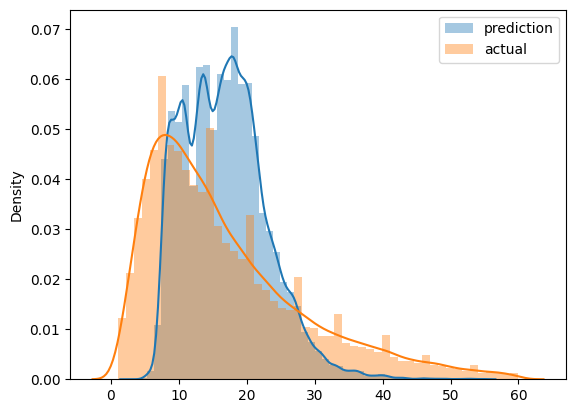

In [13]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [14]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    else:
        raise ValueError("Unsupported file format. Use .csv or .parquet")


    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [15]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [16]:
len(df_train), len(df_val)

(73908, 61921)

In [17]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [18]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [20]:


lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715203735939

In [21]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [22]:
with mlflow.start_run():

    mlflow.set_tag("developer" , "cristian")

    mlflow.log_param("train-data-path" , './data/green_tripdata_2021-01.parquet')
    mlflow.log_param("val-data-path" , './data/green_tripdata_2021-02.parquet')

    alpha = 0.05
    mlflow.log_param("alpha", alpha)

    lr = Lasso(0.01)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse" , rmse)



In [23]:
import xgboost as xgb
from hyperopt import STATUS_OK, hp,tpe,Trials, fmin
from hyperopt.pyll import scope


In [24]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [25]:
def objective(params):

    with mlflow.start_run():
        mlflow.set_tag("model" , "xgboost")
        mlflow.log_params(params=params)
        booster = xgb.train(
            params=params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )
        y_pred = booster.predict(valid)
        rmse  = root_mean_squared_error(y_val, y_pred=y_pred)
        mlflow.log_metric("rmse", rmse)

    return {"loss" : rmse , "status" : STATUS_OK}


In [28]:
search_space = {
    "max_depth" : scope.int(hp.quniform("max_depth", 4,100,1)),
    "learning_rate" : hp.loguniform("learning_rate", -3,0),
    "reg_alpha" : hp.loguniform("reg_alpha", -5,-1),
    "reg_lambda" : hp.loguniform("reg_lambda", -6,-1),
    "min-child_weight" : hp.loguniform("min_child_weight", -1, 3),
    "objective" : "reg:linear",
    "seed" : 42,
}

best_results = fmin(fn=objective,
                    space=search_space,
                    algo=tpe.suggest,
                    max_evals=50,
                    trials=Trials())

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:47:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:47:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.91344                           
[1]	validation-rmse:7.52126                           
[2]	validation-rmse:6.97807                           
[3]	validation-rmse:6.75257                           
[4]	validation-rmse:6.65432                           
[5]	validation-rmse:6.59888                           
[6]	validation-rmse:6.57368                           
[7]	validation-rmse:6.55346                           
[8]	validation-rmse:6.54511                           
[9]	validation-rmse:6.53751                           
[10]	validation-rmse:6.53463                          
[11]	validation-rmse:6.53284                          
[12]	validation-rmse:6.52796                          
[13]	validation-rmse:6.52209                          
[14]	validation-rmse:6.51886                          
[15]	validation-rmse:6.51755                          
[16]	validation-rmse:6.51499                          
[17]	validation-rmse:6.51217                          
[18]	valid

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:48:07] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:48:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.71830                                                   
[1]	validation-rmse:11.26596                                                   
[2]	validation-rmse:10.85024                                                   
[3]	validation-rmse:10.46346                                                   
[4]	validation-rmse:10.11387                                                   
[5]	validation-rmse:9.79295                                                    
[6]	validation-rmse:9.49806                                                    
[7]	validation-rmse:9.23015                                                    
[8]	validation-rmse:8.98519                                                    
[9]	validation-rmse:8.75512                                                    
[10]	validation-rmse:8.55699                                                   
[11]	validation-rmse:8.36898                                                   
[12]	validation-rmse:8.20013            

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:49:23] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:49:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.24036                                                   
[1]	validation-rmse:8.92818                                                    
[2]	validation-rmse:8.07878                                                    
[3]	validation-rmse:7.52985                                                    
[4]	validation-rmse:7.17983                                                    
[5]	validation-rmse:6.96809                                                    
[6]	validation-rmse:6.83377                                                    
[7]	validation-rmse:6.74708                                                    
[8]	validation-rmse:6.68327                                                    
[9]	validation-rmse:6.63345                                                    
[10]	validation-rmse:6.60373                                                   
[11]	validation-rmse:6.58074                                                   
[12]	validation-rmse:6.56441            

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:49:39] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:49:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.73396                                                   
[1]	validation-rmse:11.29146                                                   
[2]	validation-rmse:10.88539                                                   
[3]	validation-rmse:10.50852                                                   
[4]	validation-rmse:10.16538                                                   
[5]	validation-rmse:9.84623                                                    
[6]	validation-rmse:9.55734                                                    
[7]	validation-rmse:9.29175                                                    
[8]	validation-rmse:9.04710                                                    
[9]	validation-rmse:8.82469                                                    
[10]	validation-rmse:8.61877                                                   
[11]	validation-rmse:8.42954                                                   
[12]	validation-rmse:8.25935            

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:50:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:50:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.50328                                                   
[1]	validation-rmse:10.87783                                                   
[2]	validation-rmse:10.32384                                                   
[3]	validation-rmse:9.83425                                                    
[4]	validation-rmse:9.41074                                                    
[5]	validation-rmse:9.03701                                                    
[6]	validation-rmse:8.70938                                                    
[7]	validation-rmse:8.42633                                                    
[8]	validation-rmse:8.18090                                                    
[9]	validation-rmse:7.97002                                                    
[10]	validation-rmse:7.78456                                                   
[11]	validation-rmse:7.62690                                                   
[12]	validation-rmse:7.48943            

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:51:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.61665                                                   
[1]	validation-rmse:11.07906                                                   
[2]	validation-rmse:10.59292                                                   
[3]	validation-rmse:10.15712                                                   
[4]	validation-rmse:9.76423                                                    
[5]	validation-rmse:9.40988                                                    
[6]	validation-rmse:9.09459                                                    
[7]	validation-rmse:8.81593                                                    
[8]	validation-rmse:8.56081                                                    
[9]	validation-rmse:8.33901                                                    
[10]	validation-rmse:8.14008                                                   
[11]	validation-rmse:7.96624                                                   
[12]	validation-rmse:7.80640            

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:52:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:52:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:8.25130                                                    
[3]	validation-rmse:7.70217                                                    
[4]	validation-rmse:7.34194                                                    
[5]	validation-rmse:7.10909                                                    
[6]	validation-rmse:6.96079                                                    
[7]	validation-rmse:6.85809                                                    
[8]	validation-rmse:6.79290                                                    
[9]	validation-rmse:6.74460                                                    
[10]	validation-rmse:6.71464                                                   
[11]	validation-rmse:6.69229                                                   
[12]	validation-rmse:6.67613                                                   
[13]	validation-rmse:6.66631                                                   
[14]	validation-rmse:6.65759            

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:52:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:52:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.61906                                                    
[1]	validation-rmse:8.18738                                                    
[2]	validation-rmse:7.44479                                                    
[3]	validation-rmse:7.04322                                                    
[4]	validation-rmse:6.84733                                                    
[5]	validation-rmse:6.73195                                                    
[6]	validation-rmse:6.65791                                                    
[7]	validation-rmse:6.62046                                                    
[8]	validation-rmse:6.59369                                                    
[9]	validation-rmse:6.57786                                                    
[10]	validation-rmse:6.56859                                                   
[11]	validation-rmse:6.55924                                                   
[12]	validation-rmse:6.55385            

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:52:57] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:52:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.73549                                                    
[1]	validation-rmse:7.40192                                                    
[2]	validation-rmse:6.92035                                                    
[3]	validation-rmse:6.72472                                                    
[4]	validation-rmse:6.64510                                                    
[5]	validation-rmse:6.60782                                                    
[6]	validation-rmse:6.58854                                                    
[7]	validation-rmse:6.57520                                                    
[8]	validation-rmse:6.56636                                                    
[9]	validation-rmse:6.56036                                                    
[10]	validation-rmse:6.55509                                                   
[11]	validation-rmse:6.55115                                                   
[12]	validation-rmse:6.54921            

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:53:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:53:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.75517                                                   
[1]	validation-rmse:11.33171                                                   
[2]	validation-rmse:10.93944                                                   
[3]	validation-rmse:10.57663                                                   
[4]	validation-rmse:10.24338                                                   
[5]	validation-rmse:9.93442                                                    
[6]	validation-rmse:9.65181                                                    
[7]	validation-rmse:9.39075                                                    
[8]	validation-rmse:9.15152                                                    
[9]	validation-rmse:8.92903                                                    
[10]	validation-rmse:8.72829                                                   
[11]	validation-rmse:8.54084                                                   
[12]	validation-rmse:8.37165            

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:54:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:54:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.69147                                                    
[1]	validation-rmse:11.21434                                                    
[2]	validation-rmse:10.77728                                                    
[3]	validation-rmse:10.37938                                                    
[4]	validation-rmse:10.01378                                                    
[5]	validation-rmse:9.68330                                                     
[6]	validation-rmse:9.38078                                                     
[7]	validation-rmse:9.10742                                                     
[8]	validation-rmse:8.86334                                                     
[9]	validation-rmse:8.64023                                                     
[10]	validation-rmse:8.43598                                                    
[11]	validation-rmse:8.25322                                                    
[12]	validation-rmse:8.08719

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.07985                                                    
[1]	validation-rmse:8.72372                                                     
[2]	validation-rmse:7.88895                                                     
[3]	validation-rmse:7.35882                                                     
[4]	validation-rmse:7.06016                                                     
[5]	validation-rmse:6.88260                                                     
[6]	validation-rmse:6.76280                                                     
[7]	validation-rmse:6.68793                                                     
[8]	validation-rmse:6.64018                                                     
[9]	validation-rmse:6.60371                                                     
[10]	validation-rmse:6.57276                                                    
[11]	validation-rmse:6.55851                                                    
[12]	validation-rmse:6.54726

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.47434                                                    
[1]	validation-rmse:9.24438                                                     
[2]	validation-rmse:8.39311                                                     
[3]	validation-rmse:7.80328                                                     
[4]	validation-rmse:7.41314                                                     
[5]	validation-rmse:7.14512                                                     
[6]	validation-rmse:6.96900                                                     
[7]	validation-rmse:6.85362                                                     
[8]	validation-rmse:6.77447                                                     
[9]	validation-rmse:6.71076                                                     
[10]	validation-rmse:6.66575                                                    
[11]	validation-rmse:6.63240                                                    
[12]	validation-rmse:6.61257

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:55:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:6.88033                                                     
[2]	validation-rmse:6.72171                                                     
[3]	validation-rmse:6.67625                                                     
[4]	validation-rmse:6.65583                                                     
[5]	validation-rmse:6.64775                                                     
[6]	validation-rmse:6.64191                                                     
[7]	validation-rmse:6.63712                                                     
[8]	validation-rmse:6.63298                                                     
[9]	validation-rmse:6.62710                                                     
[10]	validation-rmse:6.62129                                                    
[11]	validation-rmse:6.61558                                                    
[12]	validation-rmse:6.60889                                                    
[13]	validation-rmse:6.60280

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:55:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:55:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.97338                                                     
[1]	validation-rmse:6.97553                                                     
[2]	validation-rmse:6.74770                                                     
[3]	validation-rmse:6.68006                                                     
[4]	validation-rmse:6.64517                                                     
[5]	validation-rmse:6.62619                                                     
[6]	validation-rmse:6.61598                                                     
[7]	validation-rmse:6.60979                                                     
[8]	validation-rmse:6.60444                                                     
[9]	validation-rmse:6.59911                                                     
[10]	validation-rmse:6.59519                                                    
[11]	validation-rmse:6.58957                                                    
[12]	validation-rmse:6.58755

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.52582                                                    
[1]	validation-rmse:10.91614                                                    
[2]	validation-rmse:10.37590                                                    
[3]	validation-rmse:9.89889                                                     
[4]	validation-rmse:9.47747                                                     
[5]	validation-rmse:9.10956                                                     
[6]	validation-rmse:8.78309                                                     
[7]	validation-rmse:8.49895                                                     
[8]	validation-rmse:8.25264                                                     
[9]	validation-rmse:8.03517                                                     
[10]	validation-rmse:7.84287                                                    
[11]	validation-rmse:7.68237                                                    
[12]	validation-rmse:7.53829

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:56:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:56:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.62901                                                    
[1]	validation-rmse:11.10122                                                    
[2]	validation-rmse:10.62360                                                    
[3]	validation-rmse:10.19357                                                    
[4]	validation-rmse:9.80399                                                     
[5]	validation-rmse:9.45558                                                     
[6]	validation-rmse:9.13810                                                     
[7]	validation-rmse:8.85830                                                     
[8]	validation-rmse:8.60749                                                     
[9]	validation-rmse:8.37949                                                     
[10]	validation-rmse:8.18067                                                    
[11]	validation-rmse:8.00349                                                    
[12]	validation-rmse:7.83961

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:57:29] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:57:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[8]	validation-rmse:6.84785                                                     
[9]	validation-rmse:6.81306                                                     
[10]	validation-rmse:6.78769                                                    
[11]	validation-rmse:6.77042                                                    
[12]	validation-rmse:6.75921                                                    
[13]	validation-rmse:6.75017                                                    
[14]	validation-rmse:6.74237                                                    
[15]	validation-rmse:6.73646                                                    
[16]	validation-rmse:6.73310                                                    
[17]	validation-rmse:6.73234                                                    
[18]	validation-rmse:6.72813                                                    
[19]	validation-rmse:6.72747                                                    
[20]	validation-rmse:6.72480

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.27439                                                    
[1]	validation-rmse:8.97112                                                     
[2]	validation-rmse:8.12439                                                     
[3]	validation-rmse:7.57958                                                     
[4]	validation-rmse:7.23950                                                     
[5]	validation-rmse:7.01862                                                     
[6]	validation-rmse:6.87831                                                     
[7]	validation-rmse:6.78313                                                     
[8]	validation-rmse:6.72211                                                     
[9]	validation-rmse:6.68014                                                     
[10]	validation-rmse:6.64858                                                    
[11]	validation-rmse:6.62713                                                    
[12]	validation-rmse:6.61139

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:58:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:58:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.71496                                                    
[1]	validation-rmse:9.58911                                                     
[2]	validation-rmse:8.76130                                                     
[3]	validation-rmse:8.14508                                                     
[4]	validation-rmse:7.70274                                                     
[5]	validation-rmse:7.39611                                                     
[6]	validation-rmse:7.15949                                                     
[7]	validation-rmse:7.00049                                                     
[8]	validation-rmse:6.88786                                                     
[9]	validation-rmse:6.80007                                                     
[10]	validation-rmse:6.73827                                                    
[11]	validation-rmse:6.68921                                                    
[12]	validation-rmse:6.65177

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:58:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:58:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:10.38618                                                    
[2]	validation-rmse:9.69426                                                     
[3]	validation-rmse:9.12337                                                     
[4]	validation-rmse:8.65347                                                     
[5]	validation-rmse:8.26888                                                     
[6]	validation-rmse:7.95796                                                     
[7]	validation-rmse:7.70469                                                     
[8]	validation-rmse:7.49962                                                     
[9]	validation-rmse:7.33648                                                     
[10]	validation-rmse:7.20297                                                    
[11]	validation-rmse:7.09664                                                    
[12]	validation-rmse:7.00806                                                    
[13]	validation-rmse:6.93755

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:58:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:58:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:10.44907                                                    
[2]	validation-rmse:9.77558                                                     
[3]	validation-rmse:9.21104                                                     
[4]	validation-rmse:8.74673                                                     
[5]	validation-rmse:8.36338                                                     
[6]	validation-rmse:8.04797                                                     
[7]	validation-rmse:7.79295                                                     
[8]	validation-rmse:7.58176                                                     
[9]	validation-rmse:7.41039                                                     
[10]	validation-rmse:7.27035                                                    
[11]	validation-rmse:7.15680                                                    
[12]	validation-rmse:7.06459                                                    
[13]	validation-rmse:6.98679

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:59:23] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:59:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[10]	validation-rmse:7.23658                                                    
[11]	validation-rmse:7.14712                                                    
[12]	validation-rmse:7.07624                                                    
[13]	validation-rmse:7.01888                                                    
[14]	validation-rmse:6.97380                                                    
[15]	validation-rmse:6.93756                                                    
[16]	validation-rmse:6.91039                                                    
[17]	validation-rmse:6.88838                                                    
[18]	validation-rmse:6.87018                                                    
[19]	validation-rmse:6.85509                                                    
[20]	validation-rmse:6.84158                                                    
[21]	validation-rmse:6.83120                                                    
[22]	validation-rmse:6.82223

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:59:40] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [16:59:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:10.62857                                                    
[2]	validation-rmse:10.00247                                                    
[3]	validation-rmse:9.46731                                                     
[4]	validation-rmse:9.01281                                                     
[5]	validation-rmse:8.62871                                                     
[6]	validation-rmse:8.30723                                                     
[7]	validation-rmse:8.03726                                                     
[8]	validation-rmse:7.81032                                                     
[9]	validation-rmse:7.62143                                                     
[10]	validation-rmse:7.46237                                                    
[11]	validation-rmse:7.33168                                                    
[12]	validation-rmse:7.22371                                                    
[13]	validation-rmse:7.13036

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:00:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:9.61035                                                     
[4]	validation-rmse:9.16736                                                     
[5]	validation-rmse:8.78739                                                     
[6]	validation-rmse:8.46593                                                     
[7]	validation-rmse:8.19131                                                     
[8]	validation-rmse:7.95959                                                     
[9]	validation-rmse:7.76195                                                     
[10]	validation-rmse:7.59523                                                    
[11]	validation-rmse:7.45508                                                    
[12]	validation-rmse:7.33716                                                    
[13]	validation-rmse:7.23825                                                    
[14]	validation-rmse:7.15325                                                    
[15]	validation-rmse:7.08337

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:00:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:00:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.05344                                                    
[1]	validation-rmse:10.11525                                                    
[2]	validation-rmse:9.36326                                                     
[3]	validation-rmse:8.76876                                                     
[4]	validation-rmse:8.30072                                                     
[5]	validation-rmse:7.93312                                                     
[6]	validation-rmse:7.64219                                                     
[7]	validation-rmse:7.41501                                                     
[8]	validation-rmse:7.24374                                                     
[9]	validation-rmse:7.10802                                                     
[10]	validation-rmse:6.99968                                                    
[11]	validation-rmse:6.91730                                                    
[12]	validation-rmse:6.85163

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:01:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:01:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.98827                                                    
[1]	validation-rmse:10.01342                                                    
[2]	validation-rmse:9.24201                                                     
[3]	validation-rmse:8.64204                                                     
[4]	validation-rmse:8.17342                                                     
[5]	validation-rmse:7.81634                                                     
[6]	validation-rmse:7.53964                                                     
[7]	validation-rmse:7.32488                                                     
[8]	validation-rmse:7.16546                                                     
[9]	validation-rmse:7.04300                                                     
[10]	validation-rmse:6.94479                                                    
[11]	validation-rmse:6.87325                                                    
[12]	validation-rmse:6.81482

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:01:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:01:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.85241                                                    
[1]	validation-rmse:9.80275                                                     
[2]	validation-rmse:8.99612                                                     
[3]	validation-rmse:8.38261                                                     
[4]	validation-rmse:7.93177                                                     
[5]	validation-rmse:7.59070                                                     
[6]	validation-rmse:7.34013                                                     
[7]	validation-rmse:7.15650                                                     
[8]	validation-rmse:7.01646                                                     
[9]	validation-rmse:6.91385                                                     
[10]	validation-rmse:6.83129                                                    
[11]	validation-rmse:6.77323                                                    
[12]	validation-rmse:6.72985

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:01:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:01:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:9.68116                                                     
[2]	validation-rmse:8.86230                                                     
[3]	validation-rmse:8.25713                                                     
[4]	validation-rmse:7.81642                                                     
[5]	validation-rmse:7.49439                                                     
[6]	validation-rmse:7.26195                                                     
[7]	validation-rmse:7.09749                                                     
[8]	validation-rmse:6.97264                                                     
[9]	validation-rmse:6.88308                                                     
[10]	validation-rmse:6.81437                                                    
[11]	validation-rmse:6.76174                                                    
[12]	validation-rmse:6.72499                                                    
[13]	validation-rmse:6.69467

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:02:25] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:02:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[4]	validation-rmse:6.94050                                                     
[5]	validation-rmse:6.83396                                                     
[6]	validation-rmse:6.78020                                                     
[7]	validation-rmse:6.74784                                                     
[8]	validation-rmse:6.72824                                                     
[9]	validation-rmse:6.71542                                                     
[10]	validation-rmse:6.70709                                                    
[11]	validation-rmse:6.70038                                                    
[12]	validation-rmse:6.69804                                                    
[13]	validation-rmse:6.69527                                                    
[14]	validation-rmse:6.68867                                                    
[15]	validation-rmse:6.68509                                                    
[16]	validation-rmse:6.68055

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:02:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:02:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.83820                                                    
[1]	validation-rmse:9.78015                                                     
[2]	validation-rmse:8.97346                                                     
[3]	validation-rmse:8.36171                                                     
[4]	validation-rmse:7.91135                                                     
[5]	validation-rmse:7.56885                                                     
[6]	validation-rmse:7.32236                                                     
[7]	validation-rmse:7.14011                                                     
[8]	validation-rmse:6.99783                                                     
[9]	validation-rmse:6.89900                                                     
[10]	validation-rmse:6.82302                                                    
[11]	validation-rmse:6.76409                                                    
[12]	validation-rmse:6.71744

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:03:15] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:03:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.48905                                                     
[1]	validation-rmse:8.05663                                                     
[2]	validation-rmse:7.33185                                                     
[3]	validation-rmse:6.97620                                                     
[4]	validation-rmse:6.78479                                                     
[5]	validation-rmse:6.68688                                                     
[6]	validation-rmse:6.62996                                                     
[7]	validation-rmse:6.59358                                                     
[8]	validation-rmse:6.57215                                                     
[9]	validation-rmse:6.55888                                                     
[10]	validation-rmse:6.55059                                                    
[11]	validation-rmse:6.54550                                                    
[12]	validation-rmse:6.53731

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:03:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.82873                                                     
[1]	validation-rmse:6.75036                                                     
[2]	validation-rmse:6.74327                                                     
[3]	validation-rmse:6.73505                                                     
[4]	validation-rmse:6.73460                                                     
[5]	validation-rmse:6.72201                                                     
[6]	validation-rmse:6.72137                                                     
[7]	validation-rmse:6.71855                                                     
[8]	validation-rmse:6.71503                                                     
[9]	validation-rmse:6.72017                                                     
[10]	validation-rmse:6.71272                                                    
[11]	validation-rmse:6.70638                                                    
[12]	validation-rmse:6.70578

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:03:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:03:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.78510                                                    
[1]	validation-rmse:9.69820                                                     
[2]	validation-rmse:8.88080                                                     
[3]	validation-rmse:8.27556                                                     
[4]	validation-rmse:7.82484                                                     
[5]	validation-rmse:7.50227                                                     
[6]	validation-rmse:7.26470                                                     
[7]	validation-rmse:7.08832                                                     
[8]	validation-rmse:6.96362                                                     
[9]	validation-rmse:6.87229                                                     
[10]	validation-rmse:6.80102                                                    
[11]	validation-rmse:6.74778                                                    
[12]	validation-rmse:6.70809

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:03:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:03:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.88210                                                    
[1]	validation-rmse:9.84976                                                     
[2]	validation-rmse:9.05203                                                     
[3]	validation-rmse:8.44718                                                     
[4]	validation-rmse:7.98012                                                     
[5]	validation-rmse:7.63457                                                     
[6]	validation-rmse:7.37292                                                     
[7]	validation-rmse:7.18197                                                     
[8]	validation-rmse:7.03838                                                     
[9]	validation-rmse:6.93360                                                     
[10]	validation-rmse:6.84832                                                    
[11]	validation-rmse:6.78773                                                    
[12]	validation-rmse:6.73464

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:04:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.01682                                                     
[1]	validation-rmse:7.61812                                                     
[2]	validation-rmse:7.03174                                                     
[3]	validation-rmse:6.76887                                                     
[4]	validation-rmse:6.65966                                                     
[5]	validation-rmse:6.60065                                                     
[6]	validation-rmse:6.56377                                                     
[7]	validation-rmse:6.54112                                                     
[8]	validation-rmse:6.52828                                                     
[9]	validation-rmse:6.51884                                                     
[10]	validation-rmse:6.51147                                                    
[11]	validation-rmse:6.50738                                                    
[12]	validation-rmse:6.50132

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:04:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:11.06789                                                    
[3]	validation-rmse:10.73650                                                    
[4]	validation-rmse:10.42763                                                    
[5]	validation-rmse:10.14057                                                    
[6]	validation-rmse:9.87397                                                     
[7]	validation-rmse:9.62590                                                     
[8]	validation-rmse:9.39625                                                     
[9]	validation-rmse:9.18271                                                     
[10]	validation-rmse:8.98566                                                    
[11]	validation-rmse:8.80299                                                    
[12]	validation-rmse:8.63412                                                    
[13]	validation-rmse:8.47729                                                    
[14]	validation-rmse:8.33352

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:04:58] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:04:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.56992                                                    
[1]	validation-rmse:9.38030                                                     
[2]	validation-rmse:8.53517                                                     
[3]	validation-rmse:7.94486                                                     
[4]	validation-rmse:7.52620                                                     
[5]	validation-rmse:7.24681                                                     
[6]	validation-rmse:7.05768                                                     
[7]	validation-rmse:6.91857                                                     
[8]	validation-rmse:6.82601                                                     
[9]	validation-rmse:6.75562                                                     
[10]	validation-rmse:6.70727                                                    
[11]	validation-rmse:6.66378                                                    
[12]	validation-rmse:6.63723

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:05:18] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:05:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.48049                                                    
[1]	validation-rmse:10.83724                                                    
[2]	validation-rmse:10.26879                                                    
[3]	validation-rmse:9.77191                                                     
[4]	validation-rmse:9.34007                                                     
[5]	validation-rmse:8.96513                                                     
[6]	validation-rmse:8.63725                                                     
[7]	validation-rmse:8.35551                                                     
[8]	validation-rmse:8.11325                                                     
[9]	validation-rmse:7.90196                                                     
[10]	validation-rmse:7.71663                                                    
[11]	validation-rmse:7.56351                                                    
[12]	validation-rmse:7.42935

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:06:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:06:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.71000                                                     
[2]	validation-rmse:7.88535                                                     
[3]	validation-rmse:7.38033                                                     
[4]	validation-rmse:7.08849                                                     
[5]	validation-rmse:6.90593                                                     
[6]	validation-rmse:6.79624                                                     
[7]	validation-rmse:6.72254                                                     
[8]	validation-rmse:6.67726                                                     
[9]	validation-rmse:6.64437                                                     
[10]	validation-rmse:6.62146                                                    
[11]	validation-rmse:6.60642                                                    
[12]	validation-rmse:6.59192                                                    
[13]	validation-rmse:6.58447

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:06:17] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:06:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.90810                                                     
[1]	validation-rmse:8.51329                                                     
[2]	validation-rmse:7.68622                                                     
[3]	validation-rmse:7.22273                                                     
[4]	validation-rmse:6.95531                                                     
[5]	validation-rmse:6.80541                                                     
[6]	validation-rmse:6.71524                                                     
[7]	validation-rmse:6.65230                                                     
[8]	validation-rmse:6.60613                                                     
[9]	validation-rmse:6.58535                                                     
[10]	validation-rmse:6.56607                                                    
[11]	validation-rmse:6.55503                                                    
[12]	validation-rmse:6.54477

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:06:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:06:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.81156                                                     
[1]	validation-rmse:7.45433                                                     
[2]	validation-rmse:6.94723                                                     
[3]	validation-rmse:6.73487                                                     
[4]	validation-rmse:6.64863                                                     
[5]	validation-rmse:6.60766                                                     
[6]	validation-rmse:6.58313                                                     
[7]	validation-rmse:6.56770                                                     
[8]	validation-rmse:6.55748                                                     
[9]	validation-rmse:6.54860                                                     
[10]	validation-rmse:6.54368                                                    
[11]	validation-rmse:6.53803                                                    
[12]	validation-rmse:6.53245

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:06:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:06:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:6.80639                                                     
[3]	validation-rmse:6.71760                                                     
[4]	validation-rmse:6.68466                                                     
[5]	validation-rmse:6.66800                                                     
[6]	validation-rmse:6.65791                                                     
[7]	validation-rmse:6.65273                                                     
[8]	validation-rmse:6.64877                                                     
[9]	validation-rmse:6.64620                                                     
[10]	validation-rmse:6.64507                                                    
[11]	validation-rmse:6.63985                                                    
[12]	validation-rmse:6.63281                                                    
[13]	validation-rmse:6.63095                                                    
[14]	validation-rmse:6.63012

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:06:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:06:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.58685                                                    
[1]	validation-rmse:11.02429                                                    
[2]	validation-rmse:10.52132                                                    
[3]	validation-rmse:10.06841                                                    
[4]	validation-rmse:9.66145                                                     
[5]	validation-rmse:9.30667                                                     
[6]	validation-rmse:8.97948                                                     
[7]	validation-rmse:8.69831                                                     
[8]	validation-rmse:8.44480                                                     
[9]	validation-rmse:8.22189                                                     
[10]	validation-rmse:8.02394                                                    
[11]	validation-rmse:7.84934                                                    
[12]	validation-rmse:7.69741

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:07:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:07:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.33158                                                     
[1]	validation-rmse:7.90758                                                     
[2]	validation-rmse:7.23242                                                     
[3]	validation-rmse:6.92778                                                     
[4]	validation-rmse:6.76451                                                     
[5]	validation-rmse:6.68578                                                     
[6]	validation-rmse:6.64431                                                     
[7]	validation-rmse:6.61823                                                     
[8]	validation-rmse:6.60147                                                     
[9]	validation-rmse:6.59093                                                     
[10]	validation-rmse:6.58214                                                    
[11]	validation-rmse:6.57426                                                    
[12]	validation-rmse:6.56908

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:07:58] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:07:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.82931                                                     
[1]	validation-rmse:6.70021                                                     
[2]	validation-rmse:6.68537                                                     
[3]	validation-rmse:6.67541                                                     
[4]	validation-rmse:6.66832                                                     
[5]	validation-rmse:6.66104                                                     
[6]	validation-rmse:6.65052                                                     
[7]	validation-rmse:6.64842                                                     
[8]	validation-rmse:6.64517                                                     
[9]	validation-rmse:6.64276                                                     
[10]	validation-rmse:6.64255                                                    
[11]	validation-rmse:6.63535                                                    
[12]	validation-rmse:6.63109

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:08:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:08:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.15877                                                     
[1]	validation-rmse:6.69895                                                     
[2]	validation-rmse:6.63020                                                     
[3]	validation-rmse:6.60554                                                     
[4]	validation-rmse:6.58290                                                     
[5]	validation-rmse:6.57439                                                     
[6]	validation-rmse:6.56830                                                     
[7]	validation-rmse:6.56218                                                     
[8]	validation-rmse:6.55725                                                     
[9]	validation-rmse:6.55363                                                     
[10]	validation-rmse:6.55130                                                    
[11]	validation-rmse:6.54753                                                    
[12]	validation-rmse:6.54640

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:08:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:08:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:11.23543                                                    
[2]	validation-rmse:10.80667                                                    
[3]	validation-rmse:10.41505                                                    
[4]	validation-rmse:10.05607                                                    
[5]	validation-rmse:9.72984                                                     
[6]	validation-rmse:9.43217                                                     
[7]	validation-rmse:9.16212                                                     
[8]	validation-rmse:8.91456                                                     
[9]	validation-rmse:8.69288                                                     
[10]	validation-rmse:8.49059                                                    
[11]	validation-rmse:8.30865                                                    
[12]	validation-rmse:8.14397                                                    
[13]	validation-rmse:7.99515

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:08:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:08:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.29530                                                    
[1]	validation-rmse:10.51637                                                    
[2]	validation-rmse:9.85789                                                     
[3]	validation-rmse:9.29892                                                     
[4]	validation-rmse:8.83765                                                     
[5]	validation-rmse:8.44478                                                     
[6]	validation-rmse:8.12249                                                     
[7]	validation-rmse:7.85124                                                     
[8]	validation-rmse:7.62768                                                     
[9]	validation-rmse:7.45290                                                     
[10]	validation-rmse:7.29599                                                    
[11]	validation-rmse:7.17514                                                    
[12]	validation-rmse:7.07040

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:09:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()

/opt/anaconda3/envs/ml/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [17:09:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "min-child_weight" } are not used.

  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.62167                                                    
[1]	validation-rmse:9.45349                                                     
[2]	validation-rmse:8.61671                                                     
[3]	validation-rmse:8.01928                                                     
[4]	validation-rmse:7.59364                                                     
[5]	validation-rmse:7.29960                                                     
[6]	validation-rmse:7.10076                                                     
[7]	validation-rmse:6.95151                                                     
[8]	validation-rmse:6.85127                                                     
[9]	validation-rmse:6.77675                                                     
[10]	validation-rmse:6.72176                                                    
[11]	validation-rmse:6.67801                                                    
[12]	validation-rmse:6.65018